In [38]:
#@title 1. Instalar dependências
%pip install torch tqdm pandas scikit-learn matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


In [39]:
#@title 2. Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Device: cpu


C:\Users\peder\AppData\Local\Temp\ipykernel_6228\1176465114.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df.set_index('REPORT_DATE').resample('M').size().to_frame('count')


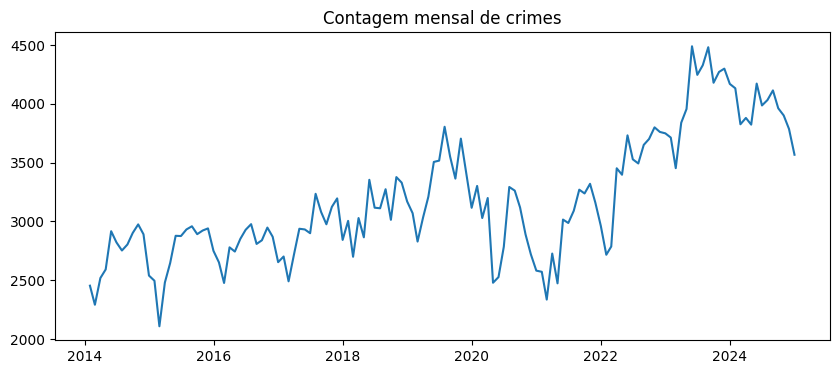

In [40]:
#@title 3. Carregar e preprocessar dados
df = pd.read_csv(
    'C:/Users/peder/Downloads/major-crime-indicators.csv',
    parse_dates=['REPORT_DATE']
)
# Agregar por mês
ts = df.set_index('REPORT_DATE').resample('M').size().to_frame('count')
# Normalizar
scaler = MinMaxScaler()
ts['scaled'] = scaler.fit_transform(ts[['count']])
data = ts['scaled'].values

# Plot contagem bruta
plt.figure(figsize=(10,4))
plt.plot(ts.index, ts['count'])
plt.title('Contagem mensal de crimes')
plt.show()

In [41]:
#@title 4. Criar sequências para treino/teste
seq_length = 12  # número de meses de histórico
X, y = [], []
for i in range(len(data) - seq_length):
    X.append(data[i:i+seq_length])
    y.append(data[i+seq_length])
X = np.array(X)
y = np.array(y)

# Split 80% train, 20% test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Ajustar tensores
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test,  dtype=torch.float32).unsqueeze(-1).to(device)
y_test  = torch.tensor(y_test,  dtype=torch.float32).to(device)

print("Shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Shapes: torch.Size([96, 12, 1]) torch.Size([96]) torch.Size([24, 12, 1]) torch.Size([24])


In [42]:
#@title 5. Definição do xLSTM e modelo de previsão
class sLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.z_gate = nn.Linear(input_size, hidden_size)
        self.i_gate = nn.Linear(input_size, hidden_size)
        self.f_gate = nn.Linear(input_size, hidden_size)
        self.o_gate = nn.Linear(input_size, hidden_size)
        self.zr_gate = nn.Linear(hidden_size, hidden_size, bias=False)
        self.ir_gate = nn.Linear(hidden_size, hidden_size, bias=False)
        self.fr_gate = nn.Linear(hidden_size, hidden_size, bias=False)
        self.or_gate = nn.Linear(hidden_size, hidden_size, bias=False)
        self.register_buffer('ht_1', torch.zeros(1, hidden_size))
        self.register_buffer('ct_1', torch.zeros(1, hidden_size))
        self.register_buffer('nt_1', torch.zeros(1, hidden_size))

    def init_states(self, batch_size):
        device = self.ht_1.device
        self.ht_1 = torch.zeros(batch_size, self.ht_1.size(1), device=device)
        self.ct_1 = torch.zeros(batch_size, self.ct_1.size(1), device=device)
        self.nt_1 = torch.zeros(batch_size, self.nt_1.size(1), device=device)

    def forward(self, x):
        z = torch.tanh(self.z_gate(x) + self.zr_gate(self.ht_1))
        i = torch.exp(self.i_gate(x) + self.ir_gate(self.ht_1))
        f = torch.exp(self.f_gate(x) + self.fr_gate(self.ht_1))
        o = torch.sigmoid(self.o_gate(x) + self.or_gate(self.ht_1))
        c = f * self.ct_1 + i * z
        n = f * self.nt_1 + i
        h = o * (c / n)
        self.ct_1 = c.detach()
        self.nt_1 = n.detach()
        self.ht_1 = h.detach()
        return h

class mLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.i_gate = nn.Linear(input_size, hidden_size)
        self.f_gate = nn.Linear(input_size, hidden_size)
        self.o_gate = nn.Linear(input_size, hidden_size)
        self.query  = nn.Linear(input_size, hidden_size)
        self.key    = nn.Linear(input_size, hidden_size)
        self.value  = nn.Linear(input_size, hidden_size)
        self.register_buffer('Ct_1', torch.zeros(1, hidden_size))
        self.register_buffer('nt_1', torch.zeros(1, hidden_size))

    def init_states(self, batch_size):
        device = self.Ct_1.device
        self.Ct_1 = torch.zeros(batch_size, self.Ct_1.size(1), device=device)
        self.nt_1 = torch.zeros(batch_size, self.nt_1.size(1), device=device)

    def forward(self, x):
        i = torch.exp(self.i_gate(x))
        f = torch.exp(self.f_gate(x))
        o = torch.sigmoid(self.o_gate(x))
        q = self.query(x)
        k = self.key(x) / (self.key.weight.shape[1] ** 0.5)
        v = self.value(x)
        C = f * self.Ct_1 + i * v * k
        n = f * self.nt_1 + i * k
        h = o * (C * q / torch.max(torch.abs(n * q)))
        self.Ct_1 = C.detach()
        self.nt_1 = n.detach()
        return h

class xLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.mlstm = mLSTMCell(input_size, hidden_size)
        self.slstm = sLSTMCell(input_size, hidden_size)

    def init_states(self, x):
        batch_size, seq_len, _ = x.shape
        self.mlstm.init_states(batch_size)
        self.slstm.init_states(batch_size)

    def forward(self, x):
        outputs = []
        for t in range(x.size(1)):
            xt = x[:, t, :]
            hm = self.mlstm(xt)
            hs = self.slstm(xt)
            outputs.append((hm + hs).unsqueeze(1))
        return torch.cat(outputs, dim=1)

class ForecastModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.xlstm = xLSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)

    def init_states(self, batch_size):
        dummy = torch.zeros(batch_size, seq_length, self.xlstm.hidden_size, device=device)
        self.xlstm.init_states(dummy)

    def forward(self, x):
        self.init_states(x.shape[0])
        out = self.xlstm(x)
        out = out[:, -1, :]
        return self.linear(out).squeeze(-1)

In [43]:
#@title 6. Treinamento
model = ForecastModel(input_size=1, hidden_size=64).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 170
batch_size = 16

for ep in range(1, epochs+1):
    model.train()
    perm = torch.randperm(X_train.size(0))
    epoch_loss = 0
    for i in range(0, len(perm), batch_size):
        idx = perm[i:i+batch_size]
        xb = X_train[idx]
        yb = y_train[idx]
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= X_train.size(0)
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        test_loss = criterion(test_pred, y_test).item()
    print(f"Ep {ep}/{epochs}, Train MSE: {epoch_loss:.4f}, Test MSE: {test_loss:.4f}")

Ep 1/170, Train MSE: 0.0206, Test MSE: 0.0875
Ep 2/170, Train MSE: 0.0179, Test MSE: 0.1082
Ep 3/170, Train MSE: 0.0165, Test MSE: 0.0658
Ep 4/170, Train MSE: 0.0143, Test MSE: 0.0548
Ep 5/170, Train MSE: 0.0129, Test MSE: 0.0449
Ep 6/170, Train MSE: 0.0119, Test MSE: 0.0271
Ep 7/170, Train MSE: 0.0109, Test MSE: 0.0188
Ep 8/170, Train MSE: 0.0105, Test MSE: 0.0134
Ep 9/170, Train MSE: 0.0105, Test MSE: 0.0131
Ep 10/170, Train MSE: 0.0107, Test MSE: 0.0092
Ep 11/170, Train MSE: 0.0096, Test MSE: 0.0110
Ep 12/170, Train MSE: 0.0095, Test MSE: 0.0089
Ep 13/170, Train MSE: 0.0091, Test MSE: 0.0092
Ep 14/170, Train MSE: 0.0090, Test MSE: 0.0093
Ep 15/170, Train MSE: 0.0092, Test MSE: 0.0090
Ep 16/170, Train MSE: 0.0086, Test MSE: 0.0101
Ep 17/170, Train MSE: 0.0087, Test MSE: 0.0083
Ep 18/170, Train MSE: 0.0086, Test MSE: 0.0104
Ep 19/170, Train MSE: 0.0096, Test MSE: 0.0102
Ep 20/170, Train MSE: 0.0085, Test MSE: 0.0081
Ep 21/170, Train MSE: 0.0082, Test MSE: 0.0130
Ep 22/170, Train MSE: 

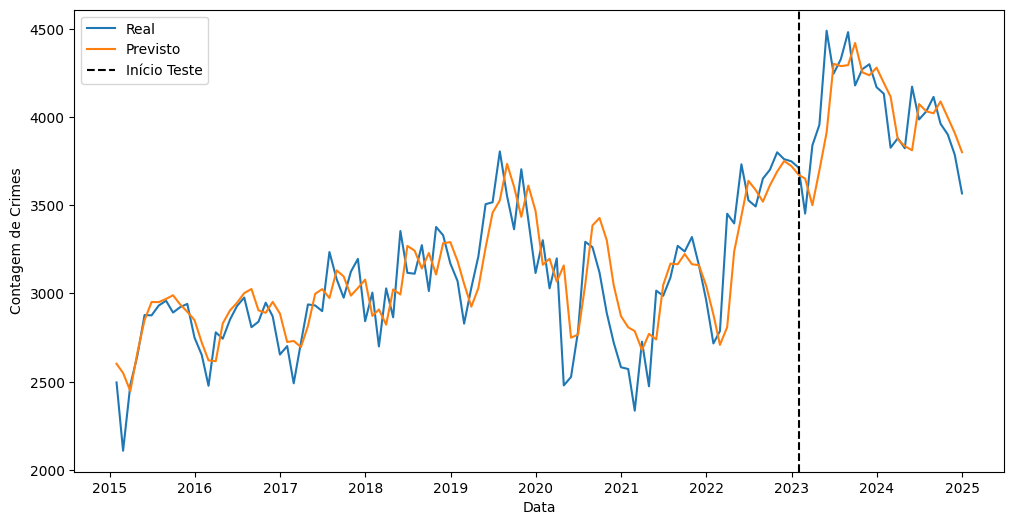

In [44]:
#@title 7. Predições e plot
model.eval()
with torch.no_grad():
    pred_train = model(X_train).cpu().numpy()
    pred_test  = model(X_test).cpu().numpy()

pred_total = np.concatenate([pred_train, pred_test])
true_total = data[seq_length:]

pred_inv = scaler.inverse_transform(pred_total.reshape(-1,1)).squeeze()
true_inv = scaler.inverse_transform(true_total.reshape(-1,1)).squeeze()
dates = ts.index[seq_length:]

plt.figure(figsize=(12,6))
plt.plot(dates, true_inv, label='Real')
plt.plot(dates, pred_inv, label='Previsto')
plt.axvline(dates[train_size], color='k', linestyle='--', label='Início Teste')
plt.xlabel('Data')
plt.ylabel('Contagem de Crimes')
plt.legend()
plt.show()